In [1]:
import sys
sys.path.append('..')
sys.path.append('../Libraries/')
import pclpy
import ARUSTUFF
import Plane
import Corners
import cv2
import imp
import glob
import os
import numpy as np
import pcl
import open3d
import pdal
from Plane import tic,toc
import segTree
import pandas as pd

from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import CameraStuff

WARNING (<module>): Couldn't load netifaces, some utils won't work


Load cloud

In [2]:
if False:
    for i in range(1,7):
        mm = pclpy.pcl.PointCloud.PointXYZ()
        pclpy.pcl.io.loadPCDFile('Clouds/downsampledlesscloudEURO'+str(i)+'.pcd',mm)
        tic()
        #miniplot
        AllGround = []
        AllNonGround = []  
        Nogroundpoints,ground = segTree.FloorRemove(mm)
        AllGround.append(ground)
        AllNonGround.append(Nogroundpoints)
        FullNonGround = [p for i in AllNonGround for p in i]
        FullGround = [p for i in AllGround for p in i]

        NongroundCloud = pclpy.pcl.PointCloud.PointXYZ(FullNonGround)
        GroundCloud = pclpy.pcl.PointCloud.PointXYZ(FullGround)

        #Corners.PCL3dpaint([NongroundCloud,GroundCloud])

        pclpy.pcl.io.savePCDFile('AllNonGroundEuroLESS'+str(i)+'.pcd',NongroundCloud, binary_mode = True)
        pclpy.pcl.io.savePCDFile('AllGroundEuroLESS'+str(i)+'.pcd',GroundCloud, binary_mode = True)
        print(toc())

In [25]:
if False:
    verticalityOPTIONS = np.arange(0.04, 0.16, 0.02)
    NonNANcurvatureOPTIONS = np.arange(0.04, 0.16, 0.02)
    lowstems_HeightOPTIONS = np.arange(2, 7, 2)
    cutstems_HeightOPTIONS = np.arange(2, 7, 2)

    lowstems_Height = 6
    cutstems_Height = 5
    len(verticalityOPTIONS),len(NonNANcurvatureOPTIONS),len(lowstems_HeightOPTIONS),len(lowstems_HeightOPTIONS)
    Register = []

In [22]:
if True:
    strieghtnessOPTIONS = np.concatenate([[0],np.arange(0.5, 0.95, 0.05)])
    lowstems_Height = 6
    cutstems_Height = 5
    print(len(strieghtnessOPTIONS))
    Register = []

10


In [25]:
for va1 in var1:
    for va2 in var2:
        print(va1,va2)
        if False:
            verticalityThresh = verticalityOPTIONS[va1]
            NonNANcurvatureThresh = NonNANcurvatureOPTIONS[va2]
        else:
            verticalityThresh = 0.06
            NonNANcurvatureThresh = 0.1
            strieghtnessThresh = strieghtnessOPTIONS[va1]
        Completeness = []
        Correctness = []
        Mean_AoD = []
        Diameter_RMSE = []
        Diameter_bias = []
        Location_RMSE = []
        Location_bias = []

        Relative_Diameter_RMSE = []
        Relative_Diameter_bias = []
        Relative_Location_RMSE = []
        Relative_Location_bias = []

        n_ref = []
        n_match = []
        n_extr = []
        location_y = []
        diameter_y = []
        try:
            for filenumber in range(1,7):
                #Load info
                print('Load info :',filenumber)
                NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
                pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/AllNonGroundEuroLESS'+str(filenumber)+'.pcd',NongroundCloud)

                groundCloud = pclpy.pcl.PointCloud.PointXYZ()
                pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/AllGroundEuroLESS'+str(filenumber)+'.pcd',groundCloud)

                #getnormals
                Ksearch=0.06
                tic()
                segcloudNor = pclpy.pcl.features.NormalEstimationOMP.PointXYZ_Normal()
                tree = pclpy.pcl.search.KdTree.PointXYZ()
                segcloudNor.setInputCloud(NongroundCloud)
                segcloudNor.setSearchMethod(tree)
                segcloudNor.setRadiusSearch(Ksearch)
                normals = pclpy.pcl.PointCloud.Normal()
                segcloudNor.compute(normals)
                print(toc())

                #Corners.PCL3dpaint([NongroundCloud.xyz,NongroundCloud.xyz+normals.normals*0.1,NongroundCloud.xyz+normals.normals*0.2])

                nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
                NonNANpoints = NongroundCloud.xyz[nanmask]
                NonNANnormals = normals.normals[nanmask]
                NonNANcurvature = normals.curvature[nanmask]
                verticality = np.dot(NonNANnormals,[[0],[0],[1]])
                mask = (verticality < verticalityThresh) & (-verticalityThresh < verticality)  #0.1
                maskC = (NonNANcurvature < NonNANcurvatureThresh)## 0.12
                Fmask = mask.ravel() & maskC.ravel()

                onlyhorizontalpoints = NonNANpoints[Fmask]
                onlyhorizontalnormals = NonNANnormals[Fmask]

                #Corners.PCL3dpaint([onlyhorizontalpoints,onlyhorizontalpoints+onlyhorizontalnormals*0.05,onlyhorizontalpoints+onlyhorizontalnormals*0.1])

                cluster_list = segTree.EucladeanClusterExtract(onlyhorizontalpoints, tol=0.1, minc=40, maxc=6000000)
                #Corners.PCL3dpaint(cluster_list)

                #Group stem segments
                composedtrees = []
                components = []
                GroupStems = []
                clustersDICT = {}

                bufferStems = cluster_list.copy()
                for n,p in enumerate(cluster_list):
                    PC1 = Plane.getPrincipalComponents(p)
                    strieghtness = PC1[0][0]/(PC1[0][0]+PC1[0][1])
                    if strieghtness>strieghtnessThresh:
                        clustersDICT = {}
                        clustersDICT['cloud'] = p
                        clustersDICT['strieghtness'] = strieghtness
                        clustersDICT['center'] = PC1[2]
                        clustersDICT['direction'] = np.array(PC1[1])
                        GroupStems.append(clustersDICT)

                bufferStems = [i['cloud'] for i in GroupStems]
                for treenumber1 in reversed(range(0,len(bufferStems))):
                    for treenumber2 in reversed(range(0,treenumber1-1)):
                        center1 = GroupStems[treenumber1]['center']
                        center2 = GroupStems[treenumber2]['center']
                        angle1 = GroupStems[treenumber1]['direction'][0]
                        angle2 = GroupStems[treenumber2]['direction'][0]
                        dist1 = Corners.DistPoint2Line(center2,angle1+center1,center1)
                        dist2 = Corners.DistPoint2Line(center1,angle2+center2,center2)
                        if (dist1<0.4) | (dist2<0.4):
                            bufferStems[treenumber2] = np.vstack([bufferStems[treenumber2],bufferStems.pop(treenumber1)])
                            break

                pointpart = groundCloud.xyz
                #groundseg = groundCloud.xyz[center]
                A = np.c_[np.ones(pointpart.shape[0]), pointpart[:,:2], np.prod(pointpart[:,:2], axis=1), pointpart[:,:2]**2]
                C,_,_,_ = np.linalg.lstsq(A, pointpart[:,2])
                #Corners.PCL3dpaint(cluster_list)

                StemsWithGround = []
                for i in bufferStems:
                    center = np.mean(i,0)
                    X,Y = center[:2]
                    Z = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], C)
                    StemsWithGround.append([i,[X,Y,Z[0]]])

                #lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (3 + i[1][2])]
                #cutstems = [i[i[:,2]<(3+np.min(i[:,2]))] for i in lowStems]

                lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (lowstems_Height + i[1][2])]
                cutstems = [[i[0][i[0][:,2]<(cutstems_Height + i[1][2])],i[1]] for i in lowStems]

                GroupLowStems = []
                for n,p in enumerate(cutstems):
                    PC1 = Plane.getPrincipalComponents(p[0])
                    strieghtness = PC1[0][0]/(PC1[0][0]+PC1[0][1])
                    if strieghtness>strieghtnessThresh:
                        GroupLowStems.append(p)

                finalstems = []
                stemcyls = []
                rech = []
                for p in cutstems:
                    segpoints = p[0]
                    indices, model = segTree.segment_normals(segpoints, searchRadius=0.1, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.01, miter=10000, distance=0.08, rlim=[0,0.4])
                    if len(indices)>0:
                        if abs(np.dot(model[3:6],[0,0,1])/np.linalg.norm(model[3:6])) > 0.5:
                            newmodel = model
                            Z = 1.3 + p[1][2]
                            Y = model[1] + model[4] * (Z - model[2]) / model[5]
                            X = model[0] + model[3] * (Z - model[2]) / model[5]
                            newmodel[0:3] = np.array([X,Y,Z])
                            newmodel[3:6] = Plane.similarize(newmodel[3:6],[0,0,1])
                            finalstems.append({'tree':segpoints[indices],'model':newmodel})
                            stemcyls.append(Corners.makecylinder(model=newmodel,length=3,dense=20))
                        else:
                            rech.append(segpoints)
                    else:
                        rech.append(segpoints)


                #####################################################
                #Get ground truth
                print('Get ground truth :',filenumber)
                treedata = pd.read_csv('..\..\Data\EuroSDR_DataRelease\EuroSDR_DataRelease/TLS_Benchmarking_Plot_'+str(filenumber)+'_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
                Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
                surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
                Zcor = 0
                TreeDict = [np.array([Xcor,Ycor,diam])]
                for i,rows in treedata.iloc[1:].iterrows():
                    Xcor,Ycor,diam = rows.iloc[[0,1,3]]
                    if not np.any(np.isnan([Xcor,Ycor,diam])):
                        surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20))
                        TreeDict.append(np.array([Xcor,Ycor,diam]))
                surtrees1 = [p for i in surtreesL1 for p in i]
                surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

                            #DataBase
                #Found trees
                #Hungarian Algorithm assignment
                print('Hungarian Algorithm assignment :',filenumber)
                CostMat = np.ones([len(TreeDict),len(stemcyls)])
                for X,datatree in enumerate(TreeDict):
                    for Y,foundtree in enumerate(finalstems):
                        CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

                dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

                #Get metrics
                print('Get metrics: ',filenumber)
                locationerror = []
                correctlocationerror = []
                diametererror = []
                cloudmatch = []
                for i,j in zip(dataindex, foundindex):
                    locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
                    if locationerror[-1]<0.4:
                        diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i][2]))        
                        correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
                    cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))


                n_ref.append(len(TreeDict))
                n_match.append(len(diametererror))
                n_extr.append(len(locationerror) - n_match[-1])
                location_y.append(np.linalg.norm(np.sum(np.array([TreeDict[i][0:2] for i in dataindex]),axis=0)/len(dataindex)))
                diameter_y.append(np.sum(np.array([finalstems[i]['model'][6]*2 for i in foundindex]),axis=0)/len(foundindex))

                Completeness.append(n_match[-1]/n_ref[-1])
                Correctness.append(n_match[-1]/(n_extr[-1]+n_match[-1]))
                Mean_AoD.append(2*n_match[-1]/(n_ref[-1]+n_extr[-1]))
                Diameter_RMSE.append(np.sqrt(np.sum(np.array(diametererror)**2)/len(diametererror)))
                Diameter_bias.append(np.sum(np.array(diametererror))/len(diametererror))
                Location_RMSE.append(np.sqrt(np.sum(np.array(correctlocationerror)**2)/len(correctlocationerror)))
                Location_bias.append(np.sum(np.array(correctlocationerror))/len(correctlocationerror))

                Relative_Diameter_RMSE.append(Diameter_RMSE[-1]/diameter_y[-1])
                Relative_Diameter_bias.append(Diameter_bias[-1]/diameter_y[-1])
                Relative_Location_RMSE.append(Location_RMSE[-1]/location_y[-1])
                Relative_Location_bias.append(Location_bias[-1]/location_y[-1])
            Register.append([verticalityThresh,NonNANcurvatureThresh,lowstems_Height,cutstems_Height,n_ref,n_match,n_extr,Completeness,Correctness,
                        Diameter_RMSE,Location_RMSE,Relative_Diameter_RMSE,Relative_Location_RMSE,strieghtnessThresh])
        except Exception as e:
            print(e)
            Register.append(e)
np.savez('saveTESTstrieghtnessThresh', Register = Register)   

0 0
Load info : 1
10.553013299999975


C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:104: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Get ground truth : 1
Hungarian Algorithm assignment : 1
Get metrics:  1
Load info : 2
10.373268800000005


C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in greater


Get ground truth : 2
Hungarian Algorithm assignment : 2
Get metrics:  2
Load info : 3
13.589148199999954
Get ground truth : 3
Hungarian Algorithm assignment : 3
Get metrics:  3
Load info : 4
14.166912199999956
Get ground truth : 4
Hungarian Algorithm assignment : 4
Get metrics:  4
Load info : 5
10.502759399999945
Get ground truth : 5
Hungarian Algorithm assignment : 5
Get metrics:  5
Load info : 6
9.32847599999991
Get ground truth : 6
Hungarian Algorithm assignment : 6
Get metrics:  6
1 0
Load info : 1
10.084551200000078
Get ground truth : 1
Hungarian Algorithm assignment : 1
Get metrics:  1
Load info : 2
9.823954599999979
Get ground truth : 2
Hungarian Algorithm assignment : 2
Get metrics:  2
Load info : 3
13.883862399999998
Get ground truth : 3
Hungarian Algorithm assignment : 3
Get metrics:  3
Load info : 4
15.664093100000173
Get ground truth : 4
Hungarian Algorithm assignment : 4
Get metrics:  4
Load info : 5
9.431743799999822
Get ground truth : 5
Hungarian Algorithm assignment : 5

In [26]:
va1

9

In [27]:
Register

[[0.06,
  0.1,
  6,
  5,
  [51, 84, 148, 78, 131, 236],
  [44, 74, 85, 49, 61, 90],
  [7, 10, 22, 11, 13, 8],
  [0.8627450980392157,
   0.8809523809523809,
   0.5743243243243243,
   0.6282051282051282,
   0.46564885496183206,
   0.3813559322033898],
  [0.8627450980392157,
   0.8809523809523809,
   0.794392523364486,
   0.8166666666666667,
   0.8243243243243243,
   0.9183673469387755],
  [0.020523221784220287,
   0.021241130898975447,
   0.023170223989867896,
   0.026970475026175496,
   0.039940426036171525,
   0.07032934991278238],
  [0.011963934710213871,
   0.0190472404263173,
   0.0390141363041013,
   0.029230400118693024,
   0.06173826808701556,
   0.06514424025672741],
  [0.09328951712243827,
   0.13332343486278628,
   0.13817570211896774,
   0.11615271060113098,
   0.20254520527940215,
   0.43160295567768103],
  [0.014116640423967736,
   0.0067636742823954385,
   0.027572889183514082,
   0.013052832476152644,
   0.37197959636253236,
   0.016503423631906832],
  0.0],
 [0.06,
  0.1

In [67]:
#PCA filtering and Eucladian Clustering
Corners.PCL3dpaint([NongroundCloud.xyz*0.98,[p for i in cluster_list for p in i]])

In [68]:
#PCA streightness and trunk grouping
Corners.PCL3dpaint([[p*0.98 for i in bufferStems for p in i],[p for i in cluster_list for p in i]])

In [106]:
Corners.PCL3dpaint([[p*0.99 for i in bufferStems for p in i],[p*0.98 for i in finalstems for p in i['tree']],[p for i in cutstems for p in i]])

In [22]:
Corners.PCL3dpaint([[p*0.99 for i in GroupLowStems for p in i[0]],[p*0.98 for i in finalstems for p in i['tree']],[p for i in stemcyls for p in i]])

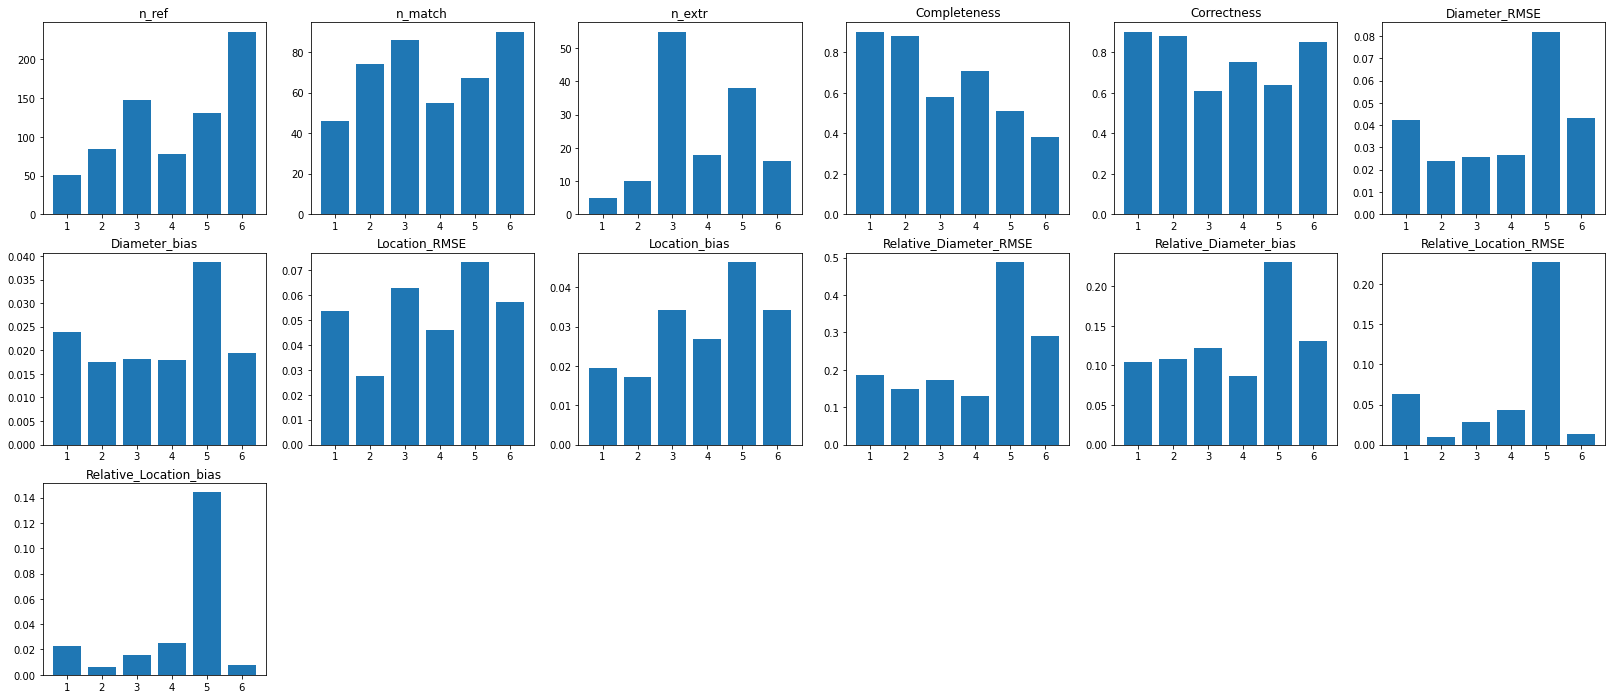

In [37]:
alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),eval(i))

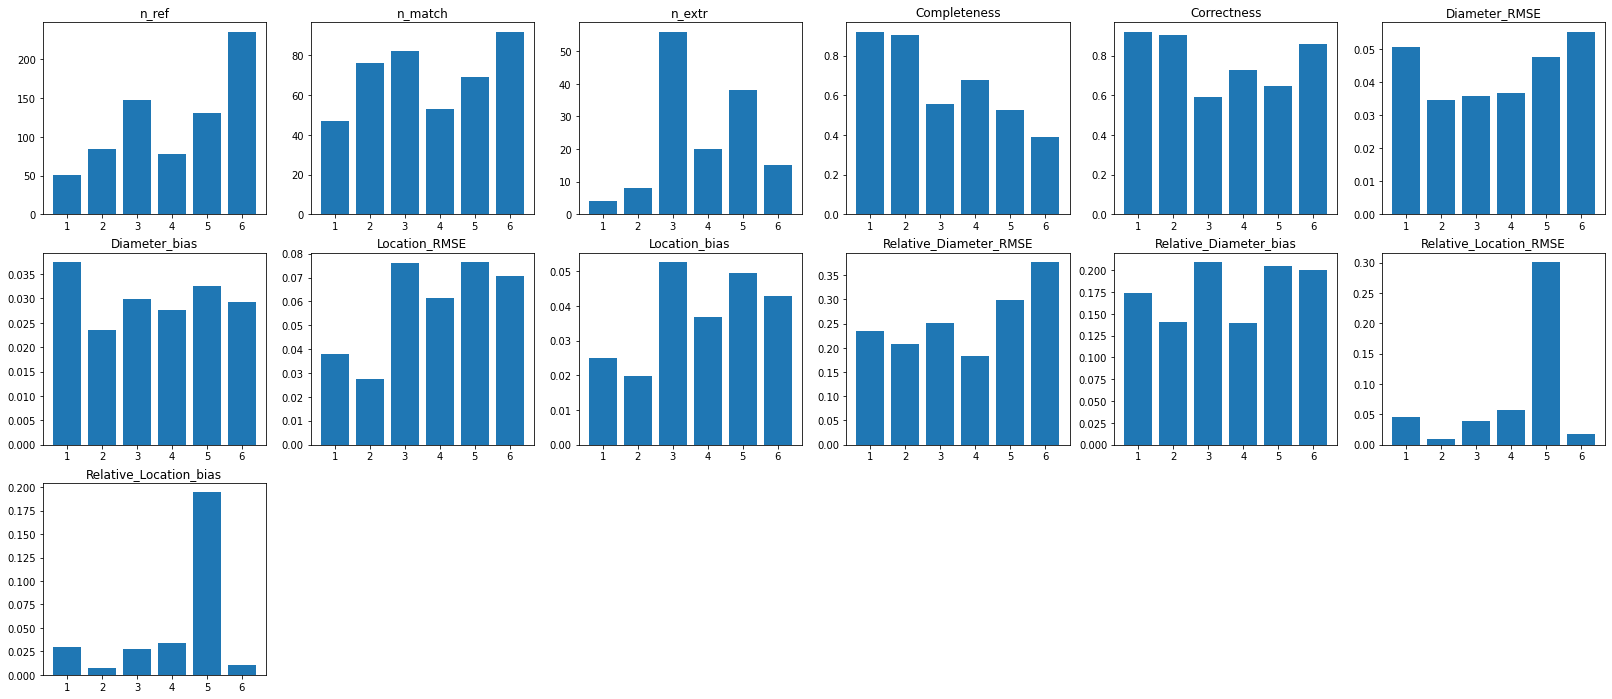

In [5]:
alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),eval(i))

In [38]:
if True:
    np.savez('resultsFGI',
             n_ref = n_ref,
             n_match = n_match,
             n_extr =n_extr,
             location_y = location_y,
             diameter_y = diameter_y, 
             Completeness = Completeness,
                    Correctness = Correctness,
                    Mean_AoD = Mean_AoD,
                    Diameter_RMSE = Diameter_RMSE,
                    Diameter_bias = Diameter_bias,
                    Location_RMSE = Location_RMSE,
                    Location_bias = Location_bias,
                    Relative_Diameter_RMSE = Relative_Diameter_RMSE,
                    Relative_Diameter_bias = Relative_Diameter_bias,
                    Relative_Location_RMSE = Relative_Location_RMSE,
                    Relative_Location_bias = Relative_Location_bias)

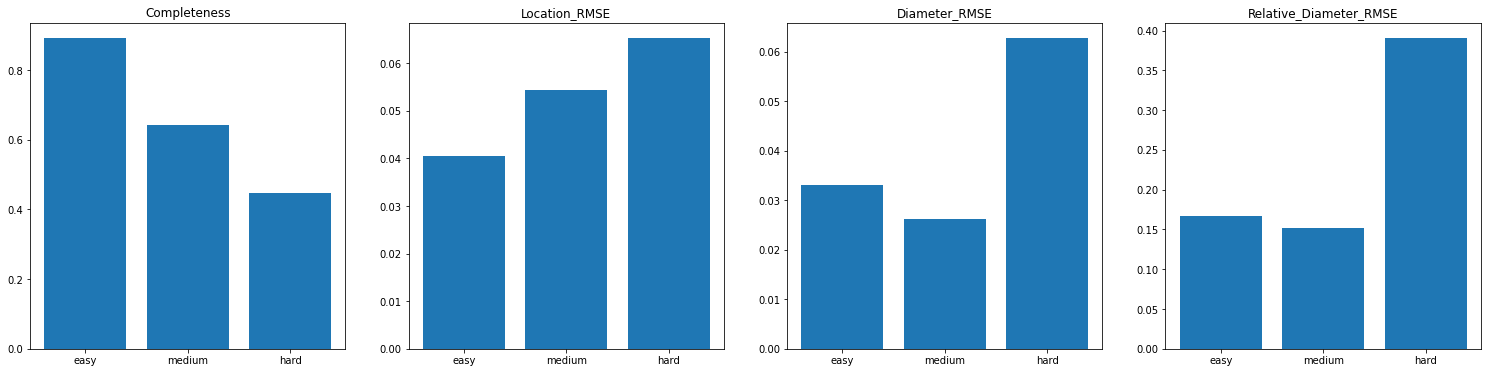

In [39]:
alldata = ['Completeness', 'Location_RMSE', 'Diameter_RMSE', 'Relative_Diameter_RMSE',]
plt.figure(figsize=(26,6))
for n,i in enumerate(alldata):
    plt.subplot(1,4,n+1)
    plt.title(i)
    avdat = [np.mean(eval(i)[slice(k,k+2)]) for k in [0,2,4]]
    plt.bar(np.array(['easy','medium','hard']),avdat)

In [40]:
fileFGI = np.load('resultsFGI.npz')
file = np.load('results.npz')

In [41]:
data = {}
dataFGI = {}
for i in alldata:
    data[i] = file[i]
    dataFGI[i] = fileFGI[i]

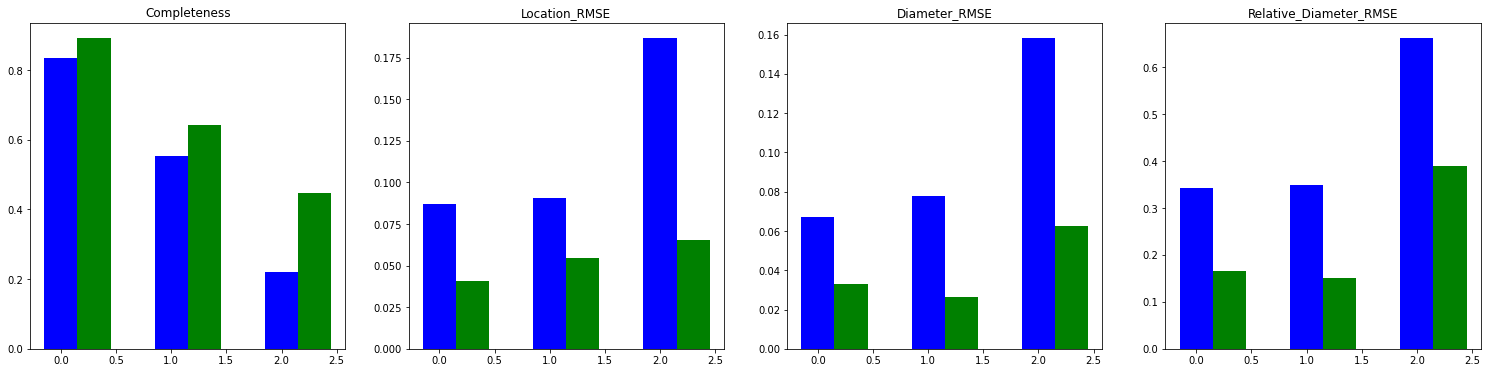

In [42]:
alldata = ['Completeness', 'Location_RMSE', 'Diameter_RMSE', 'Relative_Diameter_RMSE',]
plt.figure(figsize=(26,6))
FIG = {}
FIG = [90,87.5,65]
FIG = [0.025,0.025,0.06]
FIG = [0.025,0.025,0.025]
FIG = [0.025,0.025,0.06]
for n,i in enumerate(alldata):
    plt.subplot(1,4,n+1)
    plt.title(i)
    avdat = [np.mean(data[i][slice(k,k+2)]) for k in [0,2,4]]
    avdatFGI = [np.mean(dataFGI[i][slice(k,k+2)]) for k in [0,2,4]]
    #plt.bar(np.array(['easy','medium','hard']),avdat)
    plt.bar([0,1,2],avdat,width=0.3, color='b', align='center')
    plt.bar([0.3,1.3,2.3],avdatFGI,width=0.3, color='G', align='center')
    #plt.bar(np.array(['easy','medium','hard']),avdatFGI)